In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# Load the stock data
data = pd.read_csv("all_stock_data.csv")

# Preprocess the data
data['Date'] = pd.to_datetime(data['Date'])  # Convert Date column to datetime
# Filter the last year
last_year = datetime.now().year - 5
data = data[data['Date'].dt.year >= last_year]

# Specify the desired Ticker symbol (e.g., "AAPL" for Apple) #["AAPL", "CMG", "SBUX"]
selected_ticker = ["CMG"]
ticker_data = []
for t in selected_ticker:
    # Filter the data for the specified Ticker
    tick_data = data[data['Ticker'] == t].copy()
    # Reset the index after filtering
    tick_data.reset_index(drop=True, inplace=True)

    # Calculate target variable: change in Open/Close
    tick_data['Change'] = ((tick_data['Close'] - tick_data['Open']) / tick_data['Open'] * 100).round(2)
    # Shift the change vector by 1 to make features project into next week
    tick_data['Next Close'] = tick_data['Close'].shift(-1)
    # Drop any rows with NaN values (will occur on last row due to shifting)
    tick_data = tick_data.dropna()

    # Drop unnecessary columns
    features = ['Open', 'Close', 'High', 'Low', 'Change']
    tick_data = tick_data[features + ['Next Close']].dropna()
    tick_data.dropna()
    ticker_data.append(tick_data)

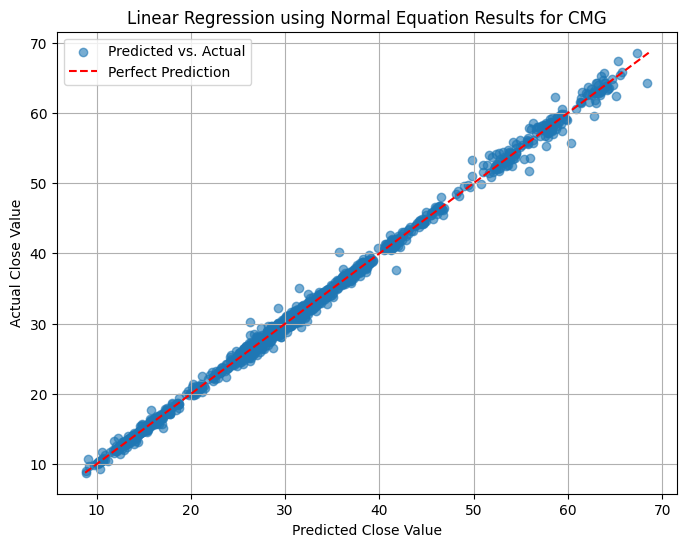

CMG - Linear Regression using Normal Equation MSE: 0.43


In [2]:
from sklearn.metrics import mean_squared_error

# Iterate through each company/ticker's data
for i, d in enumerate(ticker_data):
    # Split into features (X) and target (y)
    X = d[features].values
    y = d['Next Close'].values
    name = selected_ticker[i]

    # Linear Regression using Normal Equation
    X = np.c_[np.ones((X.shape[0], 1)), X]
    theta_linear = np.linalg.inv(X.T @ X) @ X.T @ y

    # Predictions on the training set
    y_pred = X @ theta_linear

    # Plot predictions
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, y, alpha=0.6, label="Predicted vs. Actual")
    plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--', label='Perfect Prediction')
    plt.title(f"Linear Regression using Normal Equation Results for {name}")
    plt.xlabel("Predicted Close Value")
    plt.ylabel("Actual Close Value")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate MSE
    mse = mean_squared_error(y, y_pred)
    print(f"{name} - Linear Regression using Normal Equation MSE: {mse:.2f}")


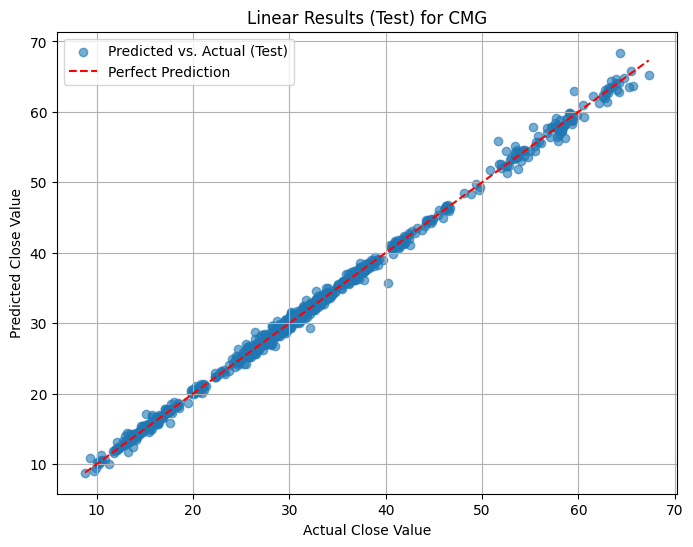

CMG - Linear Regression Test MSE: 0.39


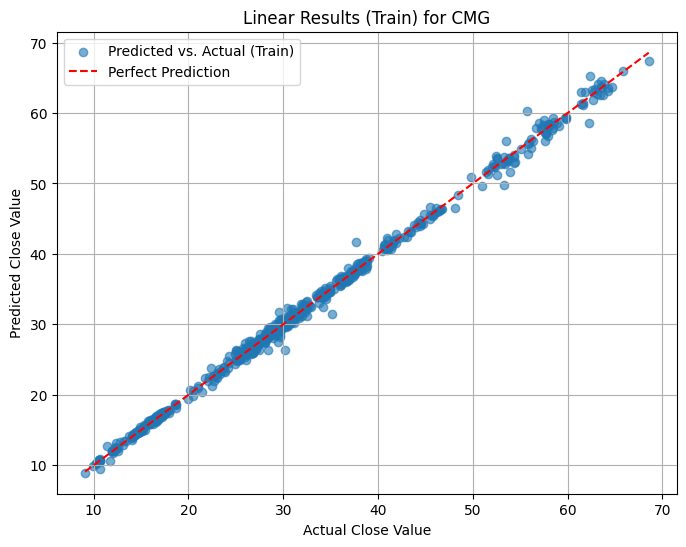

CMG - Linear Regression Train MSE: 0.49


In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Iterate through each company/ticker's data
for i, d in enumerate(ticker_data):
    # Split into features (X) and target (y)
    X = d[features].values
    y = d['Next Close'].values
    name = selected_ticker[i]
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.6, random_state=42)

    # Traditional Statistical Model - Linear Regression
    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)
    
    # Predictions on train and test sets
    y_train_pred = linear_model.predict(X_train)
    y_test_pred = linear_model.predict(X_test)

    # Plot predictions for test set
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_test_pred, alpha=0.6, label="Predicted vs. Actual (Test)")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
    plt.title(f"Linear Results (Test) for {name}")
    plt.xlabel("Actual Close Value")
    plt.ylabel("Predicted Close Value")
    plt.legend()
    plt.grid(True)
    plt.show()

    test_mse = mean_squared_error(y_test, y_test_pred)
    print(f"{name} - Linear Regression Test MSE: {test_mse:.2f}")
    
    # Plot predictions for train set
    plt.figure(figsize=(8, 6))
    plt.scatter(y_train, y_train_pred, alpha=0.6, label="Predicted vs. Actual (Train)")
    plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--', label='Perfect Prediction')
    plt.title(f"Linear Results (Train) for {name}")
    plt.xlabel("Actual Close Value")
    plt.ylabel("Predicted Close Value")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate MSE for train and test sets
    train_mse = mean_squared_error(y_train, y_train_pred)
    print(f"{name} - Linear Regression Train MSE: {train_mse:.2f}")

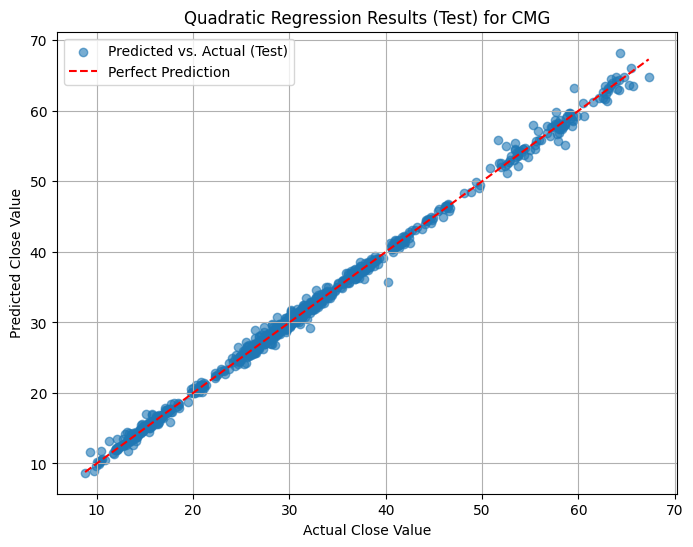

CMG - Quadratic Regression Test MSE: 0.44


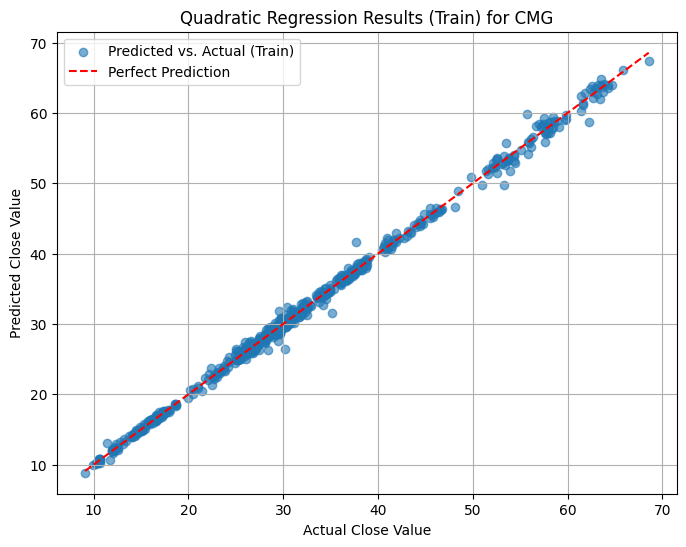

CMG - Quadratic Regression Train MSE: 0.46


In [4]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

# Iterate through each company/ticker's data
for i, d in enumerate(ticker_data):
    # Split into features (X) and target (y)
    X = d[features].values
    y = d['Next Close'].values
    name = selected_ticker[i]

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.6, random_state=42)

    # Generate polynomial features (quadratic terms)
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Train the model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    # Predictions on train and test sets
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)

    # Plot predictions for test set
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_test_pred, alpha=0.6, label="Predicted vs. Actual (Test)")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
    plt.title(f"Quadratic Regression Results (Test) for {name}")
    plt.xlabel("Actual Close Value")
    plt.ylabel("Predicted Close Value")
    plt.legend()
    plt.grid(True)
    plt.show()

    test_mse = mean_squared_error(y_test, y_test_pred)
    print(f"{name} - Quadratic Regression Test MSE: {test_mse:.2f}")
    
    # Plot predictions for train set
    plt.figure(figsize=(8, 6))
    plt.scatter(y_train, y_train_pred, alpha=0.6, label="Predicted vs. Actual (Train)")
    plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--', label='Perfect Prediction')
    plt.title(f"Quadratic Regression Results (Train) for {name}")
    plt.xlabel("Actual Close Value")
    plt.ylabel("Predicted Close Value")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate MSE for train and test sets
    train_mse = mean_squared_error(y_train, y_train_pred)
    print(f"{name} - Quadratic Regression Train MSE: {train_mse:.2f}")

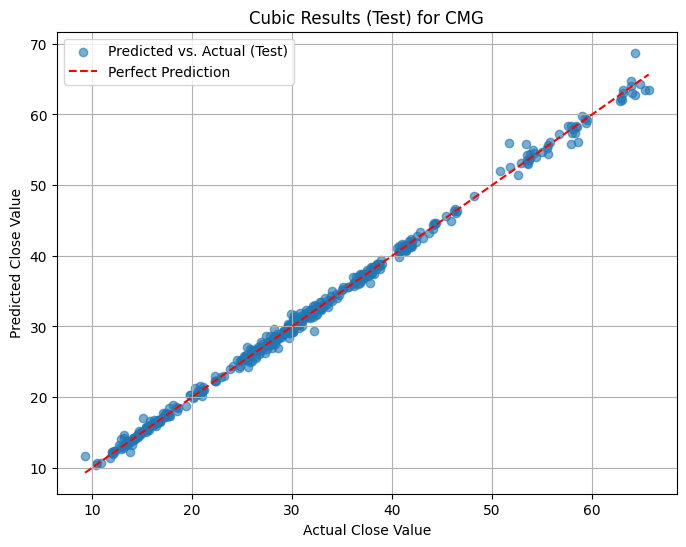

CMG - Cubic Regression Test MSE: 0.43


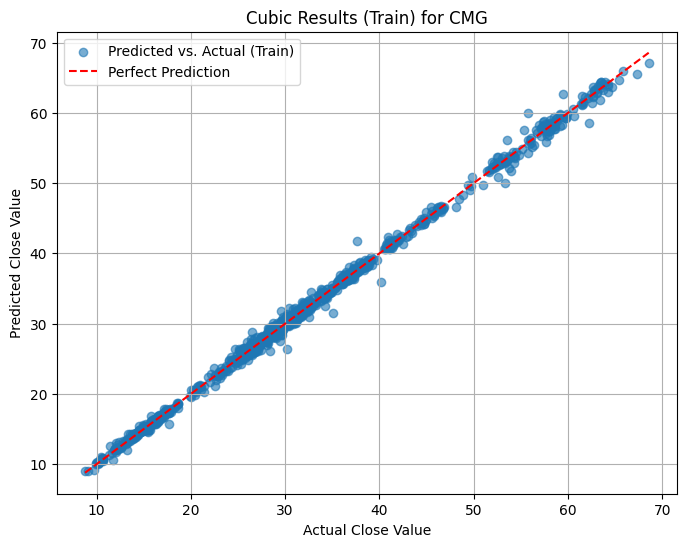

CMG - Cubic Regression Train MSE: 0.41


In [11]:
# Iterate through each company/ticker's data
for i, d in enumerate(ticker_data):
    # Split into features (X) and target (y)
    X = d[features].values
    y = d['Next Close'].values
    name = selected_ticker[i]
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

    # Generate polynomial features (cubic terms)
    cubic = PolynomialFeatures(degree=3, include_bias=False)
    X_train_poly = cubic.fit_transform(X_train)
    X_test_poly = cubic.transform(X_test)

    # Train the model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    # Predictions on train and test sets
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)

    # Plot predictions for test set
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_test_pred, alpha=0.6, label="Predicted vs. Actual (Test)")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
    plt.title(f"Cubic Results (Test) for {name}")
    plt.xlabel("Actual Close Value")
    plt.ylabel("Predicted Close Value")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate and print MSE for test set
    test_mse = mean_squared_error(y_test, y_test_pred)
    print(f"{name} - Cubic Regression Test MSE: {test_mse:.2f}")

    # Plot predictions for train set
    plt.figure(figsize=(8, 6))
    plt.scatter(y_train, y_train_pred, alpha=0.6, label="Predicted vs. Actual (Train)")
    plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--', label='Perfect Prediction')
    plt.title(f"Cubic Results (Train) for {name}")
    plt.xlabel("Actual Close Value")
    plt.ylabel("Predicted Close Value")  # Corrected indentation
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate and print MSE for train set
    train_mse = mean_squared_error(y_train, y_train_pred)
    print(f"{name} - Cubic Regression Train MSE: {train_mse:.2f}")

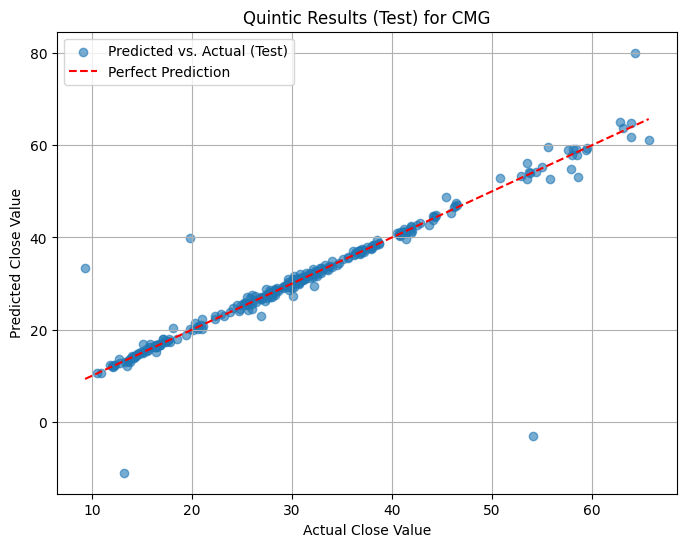

CMG - Quintic Regression Test MSE: 18.11


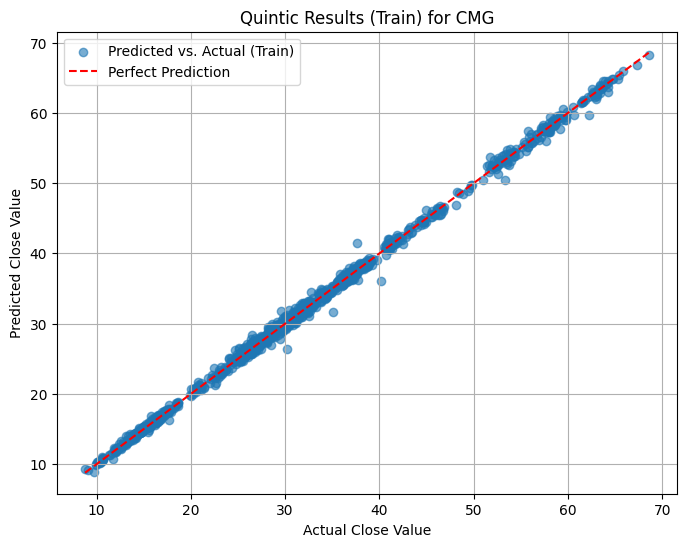

CMG - Quintic Regression Train MSE: 0.29


In [17]:
# Iterate through each company/ticker's data
for i, d in enumerate(ticker_data):
    # Split into features (X) and target (y)
    X = d[features].values
    y = d['Next Close'].values
    name = selected_ticker[i]
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Generate polynomial features (quintic terms)
    quintic = PolynomialFeatures(degree=5, include_bias=False)
    X_train_poly = quintic.fit_transform(X_train)
    X_test_poly = quintic.transform(X_test)

    # Train the model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    # Predictions on train and test sets
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)

    # Plot predictions for test set
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_test_pred, alpha=0.6, label="Predicted vs. Actual (Test)")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
    plt.title(f"Quintic Results (Test) for {name}")
    plt.xlabel("Actual Close Value")
    plt.ylabel("Predicted Close Value")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate and print MSE for test set
    test_mse = mean_squared_error(y_test, y_test_pred)
    print(f"{name} - Quintic Regression Test MSE: {test_mse:.2f}")

    # Plot predictions for train set
    plt.figure(figsize=(8, 6))
    plt.scatter(y_train, y_train_pred, alpha=0.6, label="Predicted vs. Actual (Train)")
    plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--', label='Perfect Prediction')
    plt.title(f"Quintic Results (Train) for {name}")
    plt.xlabel("Actual Close Value")
    plt.ylabel("Predicted Close Value")  # Corrected indentation
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate and print MSE for train set
    train_mse = mean_squared_error(y_train, y_train_pred)
    print(f"{name} - Quintic Regression Train MSE: {train_mse:.2f}")

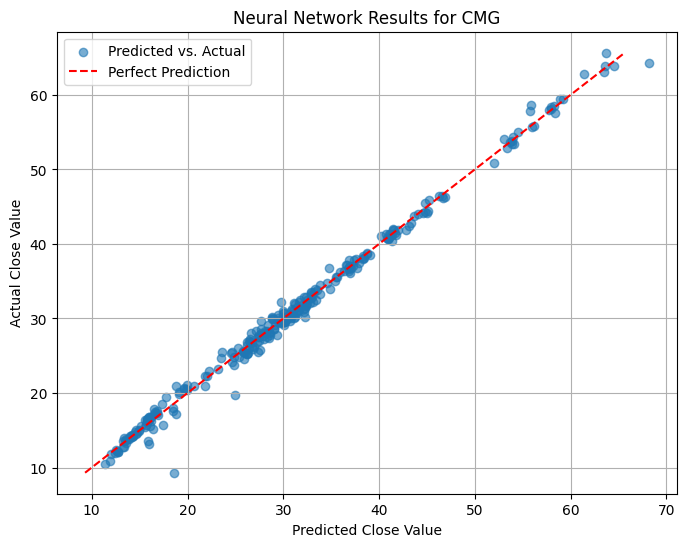

CMG - Neural Network Train MSE: 0.80, Test MSE: 1.02


In [6]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold, cross_val_score

# Iterate through each company/ticker's data
for i, d in enumerate(ticker_data):
    # Split into features (X) and target (y)
    X = d[features].values
    y = d['Next Close'].values
    name = selected_ticker[i]
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    #Neural Network model
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Initialize the neural network
    model = MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam', 
        max_iter=10000,
        early_stopping=True,
        random_state=42)

    # Fit the model and evaluate on the test set
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Visualize predictions (scatter plot)
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_pred, y_test, alpha=0.6, label="Predicted vs. Actual")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
    plt.title(f"Neural Network Results for {name}")
    plt.xlabel("Predicted Close Value")
    plt.ylabel("Actual Close Value")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Calculate MSE
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    print(f"{name} - Neural Network Train MSE: {train_mse:.2f}, Test MSE: {test_mse:.2f}")

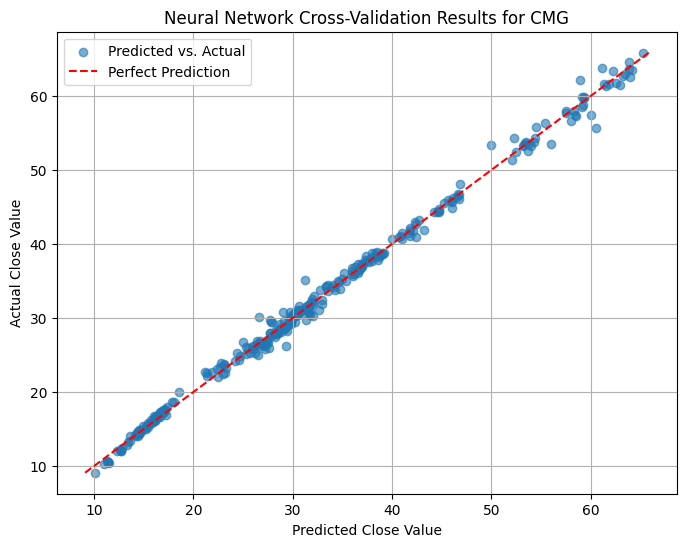

CMG - Neural Network Cross-Validation Train MSE: 0.60
CMG - Neural Network Cross-Validation Test MSE: 0.76


In [7]:
# Iterate through each company/ticker's data
for i, d in enumerate(ticker_data):
    # Split into features (X) and target (y)
    X = d[features].values
    y = d['Next Close'].values
    name = selected_ticker[i]
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    #Neural Network model
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Initialize the neural network
    model = MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam', 
        max_iter=10000,
        early_stopping=True,
        random_state=42)

    # Perform cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Cross-validated predictions for train and test
    train_mse_scores = []
    test_mse_scores = []
    for train_index, test_index in kfold.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Fit the model
        model.fit(X_train, y_train)

        # Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Calculate MSE
        train_mse_scores.append(mean_squared_error(y_train, y_train_pred))
        test_mse_scores.append(mean_squared_error(y_test, y_test_pred))

    # Plot predicted vs. actual values from the last fold
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_pred, y_test, alpha=0.6, label="Predicted vs. Actual")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
    plt.title(f"Neural Network Cross-Validation Results for {name}")
    plt.xlabel("Predicted Close Value")
    plt.ylabel("Actual Close Value")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print average MSE for train and test
    print(f"{name} - Neural Network Cross-Validation Train MSE: {np.mean(train_mse_scores):.2f}")
    print(f"{name} - Neural Network Cross-Validation Test MSE: {np.mean(test_mse_scores):.2f}")

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout

# Iterate through each company/ticker's data
for i, d in enumerate(ticker_data):
    # Split into features (X) and target (y)
    X = d[features].values
    y = d['Next Close'].values
    name = selected_ticker[i]
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Reshape X to (samples, timesteps, features) for CNN
    # Assume each sample has a single timestep with all features as input
    X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)  # Shape: (samples, timesteps, features)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

    # Define the CNN model
    model = Sequential([
        Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)),
        Dropout(0.2),
        Conv1D(filters=64, kernel_size=2, activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1)  # Single output for regression
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Visualize predictions
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_pred, y_test, alpha=0.6, label="Predicted vs. Actual")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
    plt.title(f"CNN Results for {name}")
    plt.xlabel("Predicted Close Value")
    plt.ylabel("Actual Close Value")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate MSE
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    print(f"{name} - CNN Train MSE: {train_mse:.2f}, Test MSE: {test_mse:.2f}")


SyntaxError: invalid syntax (pywrap_tensorflow_internal.py, line 114)